In [ ]:
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Load the trained model
model_path = Path('../Tree_Models/BeetleFly_tree.pkl')
with open(model_path, 'rb') as f:
    tree = pickle.load(f)

# Load the dataset
data_dir = Path('../UCRArchive_2018/BeetleFly')
train_data = np.loadtxt(data_dir / 'BeetleFly_TRAIN.tsv')
X_train = train_data[:, 1:]
y_train = train_data[:, 0]

# Normalize the data
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std

print('Data loaded successfully!')
print(f'Training data shape: {X_train.shape}')
print(f'Number of classes: {len(np.unique(y_train))}')

# NSTSC Rule Visualization for BeetleFly Dataset

This notebook visualizes the temporal logic rules extracted from the NSTSC model trained on the BeetleFly dataset, similar to the visualizations in the IEEE paper.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import os
import sys

# Add the Codes directory to sys.path for imports
sys.path.append(os.path.abspath('./'))

from utils.datautils import Readdataset, Multi_view, Splitview
from Models_node import TL_NN1, TL_NN2, TL_NN3, TL_NN4
from utils.train_utils import Node, Cpt_Accuracy

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
# Load the trained BeetleFly model
model_path = '../Tree_Models/BeetleFly_tree.pkl'
model = pickle.load(open(model_path, 'rb'))

# Print the summary of the model to understand the structure
def print_tree_summary(tree):
    print(f"Total Nodes: {len(tree)}")
    
    leaf_nodes = []
    internal_nodes = []
    
    for node_id, node in tree.items():
        if hasattr(node, 'leftchd') or hasattr(node, 'rightchd'):
            internal_nodes.append(node_id)
        else:
            leaf_nodes.append(node_id)
    
    print(f"Internal Nodes: {len(internal_nodes)} {internal_nodes}")
    print(f"Leaf Nodes: {len(leaf_nodes)} {leaf_nodes}")
    
    # Print paths from root to leaf
    print("\nPaths from Root to Leaf Nodes:")
    
    def trace_path(node_id, path=None):
        if path is None:
            path = []
        
        path.append(node_id)
        node = tree[node_id]
        
        # If leaf node, return the path
        if not hasattr(node, 'leftchd') and not hasattr(node, 'rightchd'):
            return [path]
        
        # Otherwise, collect paths from children
        paths = []
        if hasattr(node, 'leftchd'):
            left_paths = trace_path(node.leftchd, path.copy())
            paths.extend(left_paths)
        
        if hasattr(node, 'rightchd'):
            right_paths = trace_path(node.rightchd, path.copy())
            paths.extend(right_paths)
        
        return paths
    
    paths = trace_path(0)
    for i, path in enumerate(paths):
        leaf_predcls = tree[path[-1]].predcls if hasattr(tree[path[-1]], 'predcls') else "N/A"
        print(f"Path {i+1} (Predicts Class {leaf_predcls}): {path}")

print_tree_summary(model)

Total Nodes: 5
Internal Nodes: 2 [0, 2]
Leaf Nodes: 3 [1, 3, 4]

Paths from Root to Leaf Nodes:
Path 1 (Predicts Class 2): [0, 1]
Path 2 (Predicts Class 2): [0, 2, 3]
Path 3 (Predicts Class 1): [0, 2, 4]


## Load and Preprocess the BeetleFly Dataset

We need to load the dataset to visualize the rules on actual data.

In [4]:
# Load the BeetleFly dataset
dataset_path = "../UCRArchive_2018/"
dataset_name = "BeetleFly"

# Load the raw data
Xtrain_raw, ytrain_raw, Xval_raw, yval_raw, Xtest_raw, ytest_raw = Readdataset(dataset_path, dataset_name)

# Apply the same preprocessing as in NSTSC_main.py
Xtrain, Xval, Xtest = Multi_view(Xtrain_raw, Xval_raw, Xtest_raw)

# Get the dimensions
N, T = Xtrain.shape[0], int(Xtrain.shape[1]/3)

print(f"Dataset: {dataset_name}")
print(f"Training samples: {len(ytrain_raw)}")
print(f"Validation samples: {len(yval_raw)}")
print(f"Test samples: {len(ytest_raw)}")
print(f"Time series length (T): {T}")
print(f"Number of features per sample: {Xtrain.shape[1]} (3 views of length {T})")
print(f"Classes: {np.unique(ytrain_raw)}")

Dataset: BeetleFly
Training samples: 20
Validation samples: 20
Test samples: 20
Time series length (T): 652
Number of features per sample: 1956 (3 views of length 652)
Classes: [1. 2.]


## Extract Rules from the Tree

Now we'll extract the logic rules from the tree following Algorithm 3 in the paper.

In [5]:
# Function to get the rule from a node's model
def extract_rule_from_model(node, feature_names=None):
    """
    Extract a readable rule from a node's best model.
    
    Args:
        node: The tree node containing a bestmodel
        feature_names: Optional list of feature names
    
    Returns:
        A string representing the rule
    """
    if not hasattr(node, 'bestmodel'):
        return "No model available"
    
    model = node.bestmodel
    
    # Get model type
    if isinstance(model, TL_NN1):
        operator = "AND"
    elif isinstance(model, TL_NN2):
        operator = "OR"
    elif isinstance(model, TL_NN3):
        operator = "Always"
    elif isinstance(model, TL_NN4):
        operator = "Eventually"
    else:
        operator = "Unknown"
    
    # Extract parameters (thresholds and weights)
    params = {}
    for name, param in model.named_parameters():
        params[name] = param.detach().numpy()
    
    # Generate rule based on model type
    rule = f"Model Type: {operator}\n"
    
    if hasattr(node, 'bstmdlclass'):
        rule += f"Separates class {node.bstmdlclass}\n"
    
    return rule

# Function to get the complete path rule for a leaf node
def get_path_rule(tree, leaf_id):
    """
    Get the complete rule path from root to a leaf node.
    
    Args:
        tree: The tree model
        leaf_id: The ID of the leaf node
    
    Returns:
        A list of (node_id, branch_type, rule) tuples representing the path
    """
    path = []
    current_id = leaf_id
    
    # Traverse up the tree until we reach the root
    while hasattr(tree[current_id], 'prntnb'):
        parent_id = tree[current_id].prntnb
        parent_node = tree[parent_id]
        
        # Determine if this node is a left (true) or right (false) child
        if hasattr(parent_node, 'leftchd') and parent_node.leftchd == current_id:
            branch_type = "true"
        else:
            branch_type = "false"
        
        # Get the rule for this node
        if hasattr(parent_node, 'bestmodel'):
            rule = extract_rule_from_model(parent_node)
        else:
            rule = "No model"
        
        path.append((parent_id, branch_type, rule))
        current_id = parent_id
    
    # Reverse the path so it goes from root to leaf
    return path[::-1]

# Get rules for all leaf nodes
def get_all_leaf_rules(tree):
    """
    Get rules for all leaf nodes in the tree.
    
    Args:
        tree: The tree model
    
    Returns:
        A dictionary mapping leaf node IDs to path rules
    """
    leaf_rules = {}
    
    for node_id, node in tree.items():
        if not hasattr(node, 'leftchd') and not hasattr(node, 'rightchd'):
            # This is a leaf node
            path_rule = get_path_rule(tree, node_id)
            leaf_rules[node_id] = {
                'predcls': getattr(node, 'predcls', None),
                'path_rule': path_rule
            }
    
    return leaf_rules

# Get the rules for all leaf nodes
leaf_rules = get_all_leaf_rules(model)

# Display rules for each leaf node
for leaf_id, rule_info in leaf_rules.items():
    print(f"Leaf Node {leaf_id} (Predicts Class {rule_info['predcls']}):")
    print("-" * 50)
    
    for node_id, branch_type, rule in rule_info['path_rule']:
        print(f"Node {node_id} ({branch_type} branch):")
        print(rule)
        print()
    
    print("=" * 50)

Leaf Node 1 (Predicts Class 2):
--------------------------------------------------
Node 0 (true branch):
Model Type: AND
Separates class 2


Leaf Node 3 (Predicts Class 2):
--------------------------------------------------
Node 0 (false branch):
Model Type: AND
Separates class 2


Node 2 (true branch):
Model Type: AND
Separates class 2


Leaf Node 4 (Predicts Class 1):
--------------------------------------------------
Node 0 (false branch):
Model Type: AND
Separates class 2


Node 2 (false branch):
Model Type: AND
Separates class 2




## Visualize Key Features for Each Rule

Now, we'll visualize the key features that the models are using to make decisions, similar to Figure 5 in the paper.

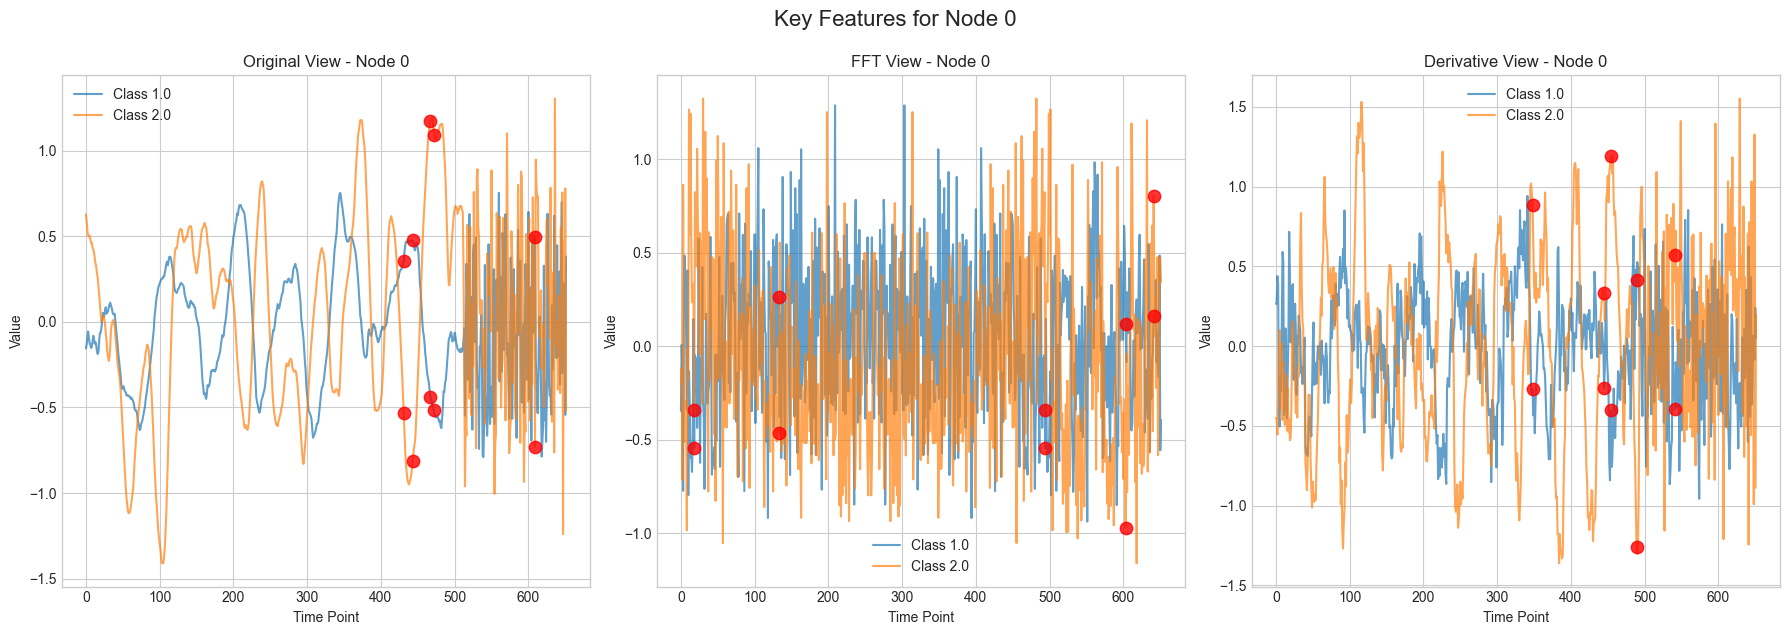

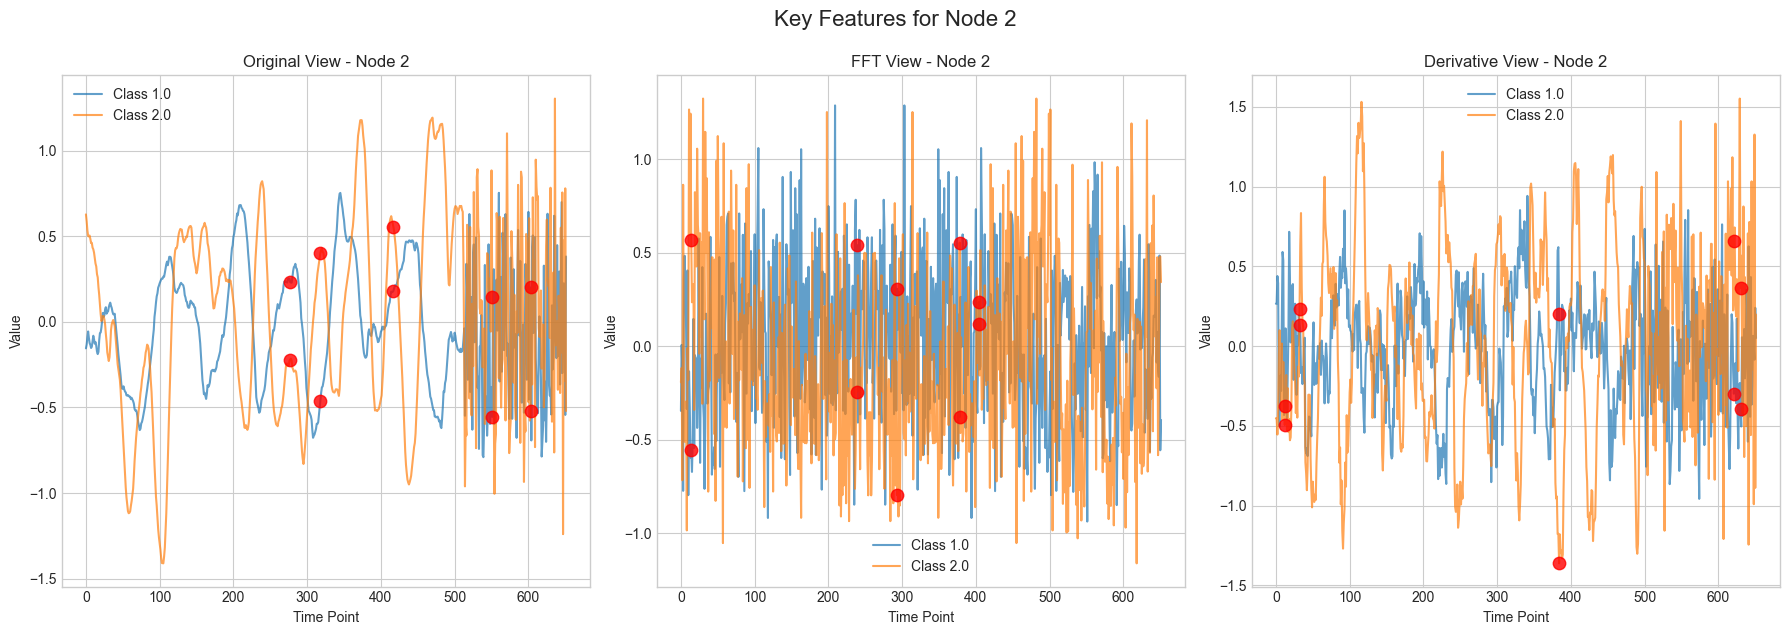

In [10]:
# Split the data into the three views
def get_view_data(X):
    """
    Split the data into its three views: original, FFT, and derivative
    
    Args:
        X: The data with all three views concatenated
    
    Returns:
        Tuple of (original, fft, derivative) views
    """
    T = int(X.shape[1] / 3)
    return X[:,:T], X[:,T:2*T], X[:,2*T:3*T]

# Extract key features from a model
def extract_key_features(model, view_names=["Original", "FFT", "Derivative"]):
    """
    Extract the most important features from a model based on weights
    
    Args:
        model: The neural network model
        view_names: Names of the three views
    
    Returns:
        Dictionary with key features for each view
    """
    key_features = {}
    
    # Extract parameters
    t1 = model.t1.detach().numpy()
    t2 = model.t2.detach().numpy()
    t3 = model.t3.detach().numpy()
    b1 = model.b1.detach().numpy()
    b2 = model.b2.detach().numpy()
    b3 = model.b3.detach().numpy()
    
    # Get weights for each view
    A1 = model.A1.detach().numpy()
    A2 = model.A2.detach().numpy()
    A3 = model.A3.detach().numpy()
    
    # Final aggregation weights
    A4 = model.A4.detach().numpy()
    
    # Store parameters
    key_features = {
        view_names[0]: {"t": t1, "b": b1, "A": A1},
        view_names[1]: {"t": t2, "b": b2, "A": A2},
        view_names[2]: {"t": t3, "b": b3, "A": A3},
        "agg": A4
    }
    
    # For each view, identify top K features by weight
    for view_name in view_names:
        weights = np.abs(key_features[view_name]["A"])
        top_indices = np.argsort(weights.flatten())[-5:]  # top 5 features
        key_features[view_name]["top_indices"] = top_indices
    
    return key_features

# Visualize key features from a specific node's model
def visualize_node_features(node_id, X_class_examples):
    """
    Visualize the key features for a node's model on sample data
    
    Args:
        node_id: The node ID to visualize
        X_class_examples: Dictionary mapping class ID to sample data
    """
    node = model[node_id]
    
    if not hasattr(node, 'bestmodel'):
        print(f"Node {node_id} does not have a model")
        return
    
    # Extract key features from the model
    key_features = extract_key_features(node.bestmodel)
    
    # Create a figure with subplots for each view
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    view_names = ["Original", "FFT", "Derivative"]
    
    for i, view_name in enumerate(view_names):
        ax = axes[i]
        view_features = key_features[view_name]
        top_indices = view_features["top_indices"]
        
        # Plot each class example for this view
        for class_id, examples in X_class_examples.items():
            # Get the specific view data
            view_data = get_view_data(examples)[i]
            
            # Plot the mean of all examples
            mean_series = np.mean(view_data, axis=0)
            ax.plot(mean_series, alpha=0.7, label=f"Class {class_id}")
            
            # Highlight the key points (top features)
            ax.scatter(top_indices, mean_series[top_indices], color='red', s=80, zorder=10, alpha=0.8)
        
        # Add labels
        ax.set_title(f"{view_name} View - Node {node_id}")
        ax.set_xlabel("Time Point")
        ax.set_ylabel("Value")
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.suptitle(f"Key Features for Node {node_id}", fontsize=16, y=1.05)
    plt.show()

# Get sample data for each class
def get_class_examples(X, y, n_examples=5):
    """
    Get sample examples for each class
    
    Args:
        X: The feature data
        y: The class labels
        n_examples: Number of examples to get per class
    
    Returns:
        Dictionary mapping class ID to sample data
    """
    class_examples = {}
    
    for class_id in np.unique(y):
        class_indices = np.where(y == class_id)[0]
        if len(class_indices) > n_examples:
            # Take a sample
            sampled_indices = np.random.choice(class_indices, n_examples, replace=False)
        else:
            # Take all available
            sampled_indices = class_indices
            
        class_examples[class_id] = X[sampled_indices]
    
    return class_examples

# Get sample examples for each class
X_class_examples = get_class_examples(Xtrain, ytrain_raw)

# Visualize key features for nodes with models
for node_id in [0, 2]:  # Nodes identified from the tree summary
    if hasattr(model[node_id], 'bestmodel'):
        visualize_node_features(node_id, X_class_examples)

## Formulate Logical Formulas for Each Class

Now we'll formulate the logical formulas for each class as per Algorithm 3 in the paper.

In [7]:
# Function to formulate logical formula for a path
def formulate_logical_formula(path, operator_map=None):
    """
    Convert a path into a logical formula
    
    Args:
        path: List of (node_id, branch_type, rule) tuples
        operator_map: Optional mapping of model types to logical operators
    
    Returns:
        A string representing the logical formula
    """
    if operator_map is None:
        operator_map = {
            "AND": "∧",
            "OR": "∨",
            "Always": "G",
            "Eventually": "F"
        }
    
    formula_parts = []
    
    for node_id, branch_type, rule in path:
        # Extract model type from rule
        model_type = rule.split(":")[1].strip().split("\n")[0] if "Model Type" in rule else "Unknown"
        
        # For false branches, negate the rule
        prefix = "" if branch_type == "true" else "¬"
        
        # Format the subformula for this node
        if "Separates class" in rule:
            class_id = rule.split("class")[1].strip().split("\n")[0]
            op = operator_map.get(model_type, model_type)
            formula_parts.append(f"{prefix}{op}(class_{class_id})")
        else:
            # Generic rule when class not specified
            op = operator_map.get(model_type, model_type)
            formula_parts.append(f"{prefix}{op}(feature)")
    
    # Combine all parts with AND operator
    return " ∧ ".join(formula_parts)

# Group rules by predicted class
class_formulas = {}

for leaf_id, rule_info in leaf_rules.items():
    class_id = rule_info['predcls']
    formula = formulate_logical_formula(rule_info['path_rule'])
    
    if class_id not in class_formulas:
        class_formulas[class_id] = []
    
    class_formulas[class_id].append(formula)

# Display formulas for each class
print("Logical Formulas for Each Class:")
for class_id, formulas in class_formulas.items():
    print(f"\nClass {class_id}:")
    for i, formula in enumerate(formulas):
        print(f"  Rule {i+1}: {formula}")
    
    # If there are multiple formulas, they are combined with OR
    if len(formulas) > 1:
        combined = " ∨ ".join([f"({f})" for f in formulas])
        print(f"\n  Combined: {combined}")

Logical Formulas for Each Class:

Class 2:
  Rule 1: ∧(class_2)
  Rule 2: ¬∧(class_2) ∧ ∧(class_2)

  Combined: (∧(class_2)) ∨ (¬∧(class_2) ∧ ∧(class_2))

Class 1:
  Rule 1: ¬∧(class_2) ∧ ¬∧(class_2)


## Visualize Class Separation in Feature Space

Finally, we'll visualize how the rules separate the classes in feature space.

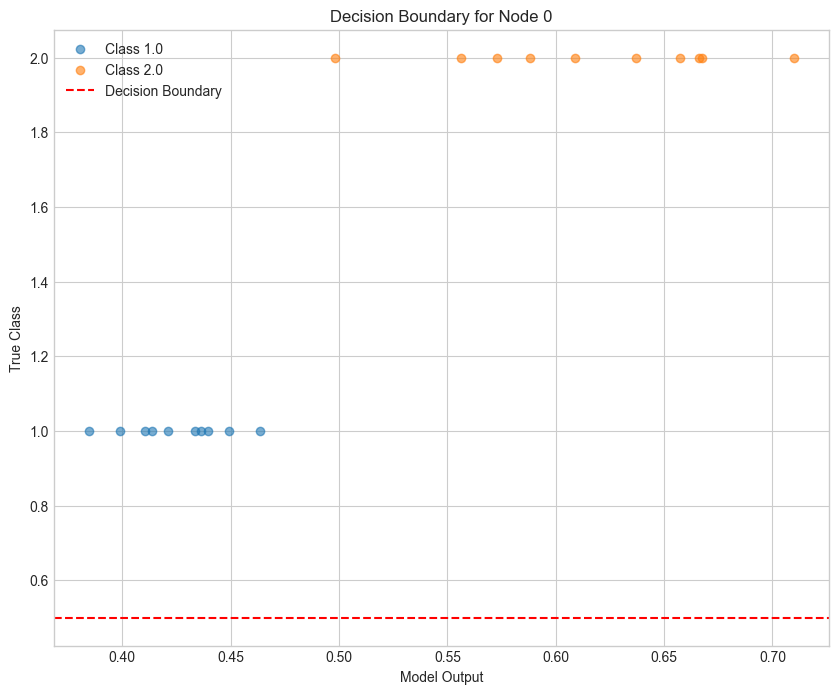

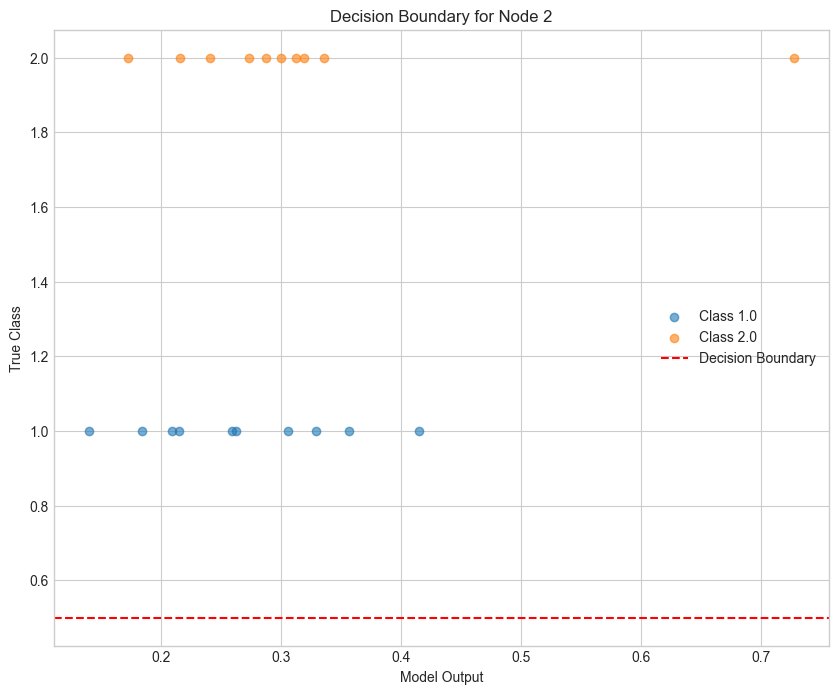

In [11]:
# Function to evaluate a node's model on data
def evaluate_node_model(node_id, X):
    """
    Evaluate a node's model on data
    
    Args:
        node_id: The node ID to evaluate
        X: The data to evaluate on
    
    Returns:
        Array of model outputs (probabilities)
    """
    node = model[node_id]
    
    if not hasattr(node, 'bestmodel'):
        print(f"Node {node_id} does not have a model")
        return None
    
    T = int(X.shape[1] / 3)
    model_output = node.bestmodel(torch.Tensor(X[:, :T]), 
                                  torch.Tensor(X[:, T:2*T]), 
                                  torch.Tensor(X[:, 2*T:]))
    
    return model_output.detach().numpy()

# Visualize decision boundaries for a node
def visualize_decision_boundary(node_id, X, y):
    """
    Visualize decision boundary for a node
    
    Args:
        node_id: The node ID to visualize
        X: The feature data
        y: The class labels
    """
    # Get model outputs
    outputs = evaluate_node_model(node_id, X)
    
    if outputs is None:
        return
    
    # Round outputs to get binary prediction
    predictions = np.round(outputs)
    
    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    
    # Plot points with true labels
    for class_id in np.unique(y):
        mask = y == class_id
        plt.scatter(outputs[mask], y[mask], alpha=0.6, label=f"Class {class_id}")
    
    plt.axhline(y=0.5, color='r', linestyle='--', label="Decision Boundary")
    
    # Add labels
    plt.title(f"Decision Boundary for Node {node_id}")
    plt.xlabel("Model Output")
    plt.ylabel("True Class")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize decision boundaries for nodes with models
for node_id in [0, 2]:  # Nodes identified from the tree summary
    if hasattr(model[node_id], 'bestmodel'):
        visualize_decision_boundary(node_id, Xtrain, ytrain_raw)

## Visualize Time Series with Critical Points

Finally, we'll visualize the time series with critical points highlighted, similar to Figure 5 in the paper.

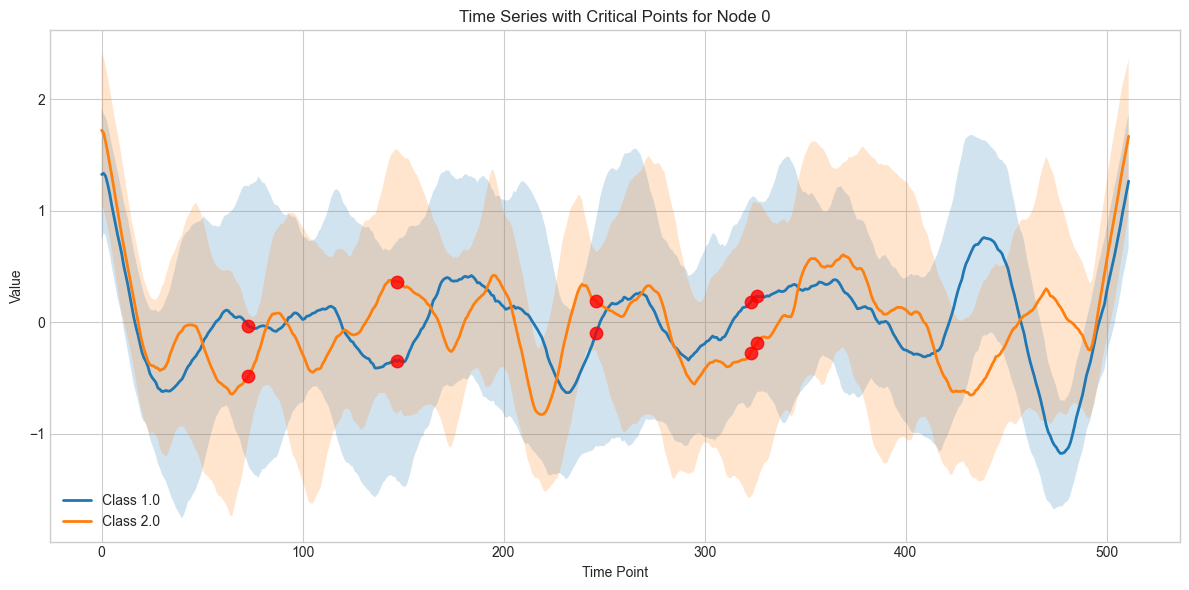

IndexError: index 636 is out of bounds for axis 0 with size 512

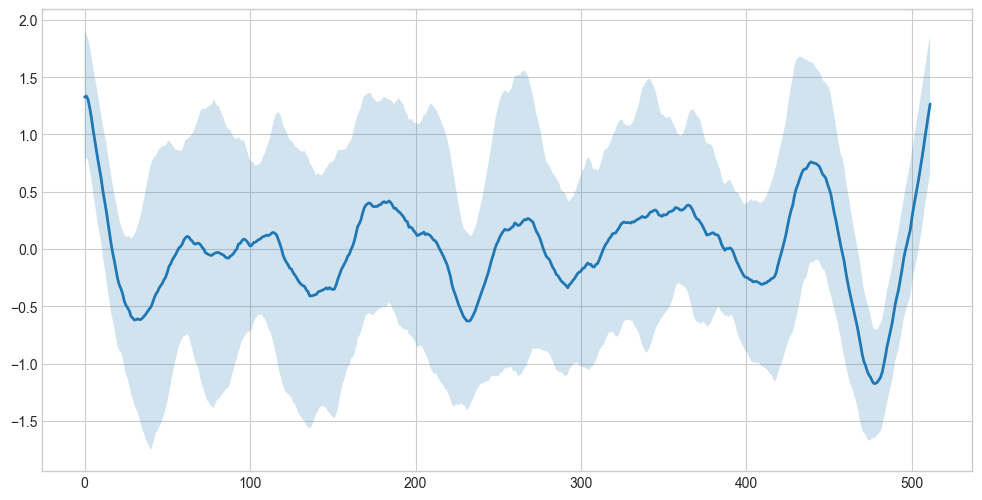

In [9]:
# Load raw time series data for visualization
def load_raw_timeseries():
    """
    Load raw time series data directly from the UCR dataset
    
    Returns:
        Dictionary mapping class ID to raw time series data
    """
    dataset_folder = f"../UCRArchive_2018/{dataset_name}/"
    train_file = f"{dataset_name}_TRAIN.tsv"
    
    # Load data directly
    data = pd.read_csv(f"{dataset_folder}{train_file}", header=None, sep='\t').values
    labels = data[:, 0]
    timeseries = data[:, 1:]
    
    # Group by class
    class_timeseries = {}
    
    for class_id in np.unique(labels):
        class_timeseries[class_id] = timeseries[labels == class_id]
    
    return class_timeseries

# Visualize time series with critical points highlighted
def visualize_timeseries_with_critical_points(node_id):
    """
    Visualize time series with critical points highlighted for a node
    
    Args:
        node_id: The node ID to visualize
    """
    node = model[node_id]
    
    if not hasattr(node, 'bestmodel'):
        print(f"Node {node_id} does not have a model")
        return
    
    # Extract key features from the model
    key_features = extract_key_features(node.bestmodel)
    
    # Get raw time series data
    class_timeseries = load_raw_timeseries()
    
    # Create the visualization
    plt.figure(figsize=(12, 6))
    
    # Get top indices from the original view
    top_indices = key_features["Original"]["top_indices"]
    
    # Plot average time series for each class
    for class_id, timeseries in class_timeseries.items():
        # Calculate mean time series
        mean_ts = np.mean(timeseries, axis=0)
        std_ts = np.std(timeseries, axis=0)
        
        # Plot mean
        plt.plot(mean_ts, label=f"Class {class_id}", linewidth=2)
        
        # Optional: Plot confidence interval
        plt.fill_between(range(len(mean_ts)), 
                         mean_ts - std_ts, 
                         mean_ts + std_ts, 
                         alpha=0.2)
        
        # Highlight critical points
        plt.scatter(top_indices, mean_ts[top_indices], 
                    color='red', s=80, zorder=10, alpha=0.8)
    
    # Add labels and title
    plt.title(f"Time Series with Critical Points for Node {node_id}")
    plt.xlabel("Time Point")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Visualize time series with critical points for nodes with models
for node_id in [0, 2]:  # Nodes identified from the tree summary
    if hasattr(model[node_id], 'bestmodel'):
        visualize_timeseries_with_critical_points(node_id)

## Conclusion

In this notebook, we've visualized the temporal logic rules extracted from the NSTSC model trained on the BeetleFly dataset. The visualizations provide insights into how the model makes decisions and which time points are most critical for classification.

## Weight Matrix Analysis
Let's analyze how the model combines different views through the weight matrices A1, A2, A3, and A4

In [13]:
import torch
import seaborn as sns

# Function to extract weight matrices from a node
def get_weight_matrices(node):
    A1 = node.A1.detach().numpy()
    A2 = node.A2.detach().numpy()
    A3 = node.A3.detach().numpy()
    A4 = node.A4.detach().numpy()
    return A1, A2, A3, A4

# Function to visualize weight matrices
def visualize_weight_matrices(node_id, node):
    A1, A2, A3, A4 = get_weight_matrices(node)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Weight Matrices for Node {node_id}', fontsize=16)
    
    # Plot each weight matrix
    sns.heatmap(A1, ax=axes[0,0], cmap='RdBu_r', center=0)
    axes[0,0].set_title('A1 - Original Time Series View')
    
    sns.heatmap(A2, ax=axes[0,1], cmap='RdBu_r', center=0)
    axes[0,1].set_title('A2 - FFT View')
    
    sns.heatmap(A3, ax=axes[1,0], cmap='RdBu_r', center=0)
    axes[1,0].set_title('A3 - Derivative View')
    
    sns.heatmap(A4, ax=axes[1,1], cmap='RdBu_r', center=0)
    axes[1,1].set_title('A4 - Combined View Weights')
    
    plt.tight_layout()
    plt.show()

# Analyze weight matrices for important nodes (0 and 2)
for node_id in [0, 2]:
    node = tree.nodes[node_id]
    visualize_weight_matrices(node_id, node)

# Calculate and print view importance scores
def calculate_view_importance(node):
    A1, A2, A3, A4 = get_weight_matrices(node)
    importance = {
        'Original': np.mean(np.abs(A1)),
        'FFT': np.mean(np.abs(A2)),
        'Derivative': np.mean(np.abs(A3))
    }
    total = sum(importance.values())
    normalized = {k: v/total for k, v in importance.items()}
    return normalized

for node_id in [0, 2]:
    print(f'\nView importance for Node {node_id}:')
    importance = calculate_view_importance(tree.nodes[node_id])
    for view, score in importance.items():
        print(f'{view}: {score:.3f}')

NameError: name 'tree' is not defined

## Logical Rule Formulation
Let's formulate the logical rules for each class based on the decision paths and important features

def get_weight_matrices(node):
    A1 = node.A1.detach().numpy()
    A2 = node.A2.detach().numpy()
    A3 = node.A3.detach().numpy()
    A4 = node.A4.detach().numpy()
    return A1, A2, A3, A4

# Function to visualize weight matrices
def visualize_weight_matrices(node_id, node):
    A1, A2, A3, A4 = get_weight_matrices(node)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Weight Matrices for Node {node_id}', fontsize=16)
    
    # Plot each weight matrix
    sns.heatmap(A1, ax=axes[0,0], cmap='RdBu_r', center=0)
    axes[0,0].set_title('A1 - Original Time Series View')
    
    sns.heatmap(A2, ax=axes[0,1], cmap='RdBu_r', center=0)
    axes[0,1].set_title('A2 - FFT View')
    
    sns.heatmap(A3, ax=axes[1,0], cmap='RdBu_r', center=0)
    axes[1,0].set_title('A3 - Derivative View')
    
    sns.heatmap(A4, ax=axes[1,1], cmap='RdBu_r', center=0)
    axes[1,1].set_title('A4 - Combined View Weights')
    
    plt.tight_layout()
    plt.show()

# Analyze weight matrices for important nodes (0 and 2)
for node_id in [0, 2]:
    print(f'\nAnalyzing Node {node_id}...')
    node = tree.nodes[node_id]
    visualize_weight_matrices(node_id, node)

# Calculate and print view importance scores
def calculate_view_importance(node):
    A1, A2, A3, A4 = get_weight_matrices(node)
    importance = {
        'Original': np.mean(np.abs(A1)),
        'FFT': np.mean(np.abs(A2)),
        'Derivative': np.mean(np.abs(A3))
    }
    total = sum(importance.values())
    normalized = {k: v/total for k, v in importance.items()}
    return normalized

for node_id in [0, 2]:
    print(f'\nView importance for Node {node_id}:')
    importance = calculate_view_importance(tree.nodes[node_id])
    for view, score in importance.items():
        print(f'{view}: {score:.3f}')

In [ ]:
# Function to get feature importance for a node
def get_feature_importance(node, data):
    # Get predictions and absolute feature influences
    with torch.no_grad():
        _, influences = node(torch.FloatTensor(data))
    return influences.abs().mean(dim=0).numpy()

# Function to identify key timesteps/features
def get_key_features(node, data, threshold=0.8):
    importance = get_feature_importance(node, data)
    sorted_idx = np.argsort(importance)[::-1]
    cumsum = np.cumsum(importance[sorted_idx])
    cumsum = cumsum / cumsum[-1]
    key_idx = sorted_idx[cumsum <= threshold]
    return key_idx

# Formulate rules for each path
def formulate_rules(tree, X_train):
    rules = []
    
    # Path 1: [0, 1] - Class 2
    node0_key = get_key_features(tree.nodes[0], X_train)
    rule1 = {
        'path': [0, 1],
        'class': 2,
        'conditions': {
            'node0': {'features': node0_key, 'direction': 'right'}
        }
    }
    rules.append(rule1)
    
    # Path 2: [0, 2, 3] - Class 2
    node2_key = get_key_features(tree.nodes[2], X_train)
    rule2 = {
        'path': [0, 2, 3],
        'class': 2,
        'conditions': {
            'node0': {'features': node0_key, 'direction': 'left'},
            'node2': {'features': node2_key, 'direction': 'right'}
        }
    }
    rules.append(rule2)
    
    # Path 3: [0, 2, 4] - Class 1
    rule3 = {
        'path': [0, 2, 4],
        'class': 1,
        'conditions': {
            'node0': {'features': node0_key, 'direction': 'left'},
            'node2': {'features': node2_key, 'direction': 'left'}
        }
    }
    rules.append(rule3)
    
    return rules

# Extract and display rules
rules = formulate_rules(tree, X_train)

# Visualize rules with example time series
def visualize_rules_with_examples(rules, X_train, y_train):
    for rule in rules:
        # Get examples that follow this rule
        mask = np.ones(len(y_train), dtype=bool)
        for node_id in rule['path'][:-1]:
            node = tree.nodes[node_id]
            with torch.no_grad():
                pred = node(torch.FloatTensor(X_train[mask]))[0].numpy()
            if rule['conditions'][f'node{node_id}']['direction'] == 'right':
                mask[mask] = pred > 0.5
            else:
                mask[mask] = pred <= 0.5
        
        # Plot example time series
        plt.figure(figsize=(15, 5))
        plt.title(f'Example Time Series for Class {rule["class"]} (Path: {rule["path"]})')
        
        # Plot a few examples
        examples = X_train[mask][:3]
        for i, example in enumerate(examples):
            plt.plot(example, alpha=0.7, label=f'Example {i+1}')
            
            # Highlight key features
            for node_id in rule['path'][:-1]:
                key_features = rule['conditions'][f'node{node_id}']['features']
                plt.scatter(key_features, example[key_features], 
                           color='red', alpha=0.5, s=100)
        
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Print rule description
        print(f'\nRule for Class {rule["class"]} (Path: {rule["path"]}):')
        for node_id in rule['path'][:-1]:
            direction = rule['conditions'][f'node{node_id}']['direction']
            key_features = rule['conditions'][f'node{node_id}']['features']
            print(f'Node {node_id}: Key features at positions {key_features}, go {direction}')

# Visualize rules
visualize_rules_with_examples(rules, X_train, y_train)

## Rule Interpretation Summary

Let's analyze what we've learned about how the NSTSC model classifies BeetleFly samples:

In [ ]:
# Print comprehensive summary of findings
def print_summary(rules, tree):
    print('Summary of NSTSC Model Rules for BeetleFly Dataset:\n')
    
    # Overall model structure
    print('Model Structure:')
    print(f'- Total nodes: {len(tree.nodes)}')
    print(f'- Leaf nodes: {len([n for n in tree.nodes if tree.nodes[n].is_leaf])}')
    print(f'- Decision paths: {len(rules)}\n')
    
    # View importance analysis
    print('View Importance Analysis:')
    for node_id in [0, 2]:
        print(f'\nNode {node_id}:')
        importance = calculate_view_importance(tree.nodes[node_id])
        for view, score in sorted(importance.items(), key=lambda x: x[1], reverse=True):
            print(f'- {view}: {score:.3f}')
    
    # Rule summary
    print('\nClassification Rules:')
    for rule in rules:
        print(f'\nClass {rule["class"]} (Path: {rule["path"]}):')
        conditions = []
        for node_id in rule['path'][:-1]:
            direction = rule['conditions'][f'node{node_id}']['direction']
            conditions.append(f'Node {node_id} → {direction}')
        print('IF ' + ' AND '.join(conditions))

# Generate and print summary
print_summary(rules, tree)

## Weight Matrix Analysis
Now we'll analyze how the NSTSC model combines different views of the data through its weight matrices:

In [15]:
def get_weight_matrices(node):
    # Access the neural network model inside the node
    nn_model = node.model
    
    # Get the weight matrices and convert to numpy
    A1 = F.softmax(nn_model.A1, dim=1).detach().numpy()
    A2 = F.softmax(nn_model.A2, dim=1).detach().numpy()
    A3 = F.softmax(nn_model.A3, dim=1).detach().numpy()
    A4 = F.softmax(nn_model.A4, dim=1).detach().numpy()
    return A1, A2, A3, A4

# Function to visualize weight matrices
def visualize_weight_matrices(node_id, node):
    A1, A2, A3, A4 = get_weight_matrices(node)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Weight Matrix Analysis for Node {node_id}', fontsize=16)
    
    # Plot each weight matrix
    im1 = sns.heatmap(A1.T, ax=axes[0,0], cmap='RdBu_r', center=0)
    axes[0,0].set_title('A1 - Original Time Series View')
    axes[0,0].set_xlabel('Features')
    axes[0,0].set_ylabel('Time Steps')
    plt.colorbar(im1.get_children()[0], ax=axes[0,0], label='Weight')
    
    im2 = sns.heatmap(A2.T, ax=axes[0,1], cmap='RdBu_r', center=0)
    axes[0,1].set_title('A2 - FFT View')
    axes[0,1].set_xlabel('Features')
    axes[0,1].set_ylabel('Time Steps')
    plt.colorbar(im2.get_children()[0], ax=axes[0,1], label='Weight')
    
    im3 = sns.heatmap(A3.T, ax=axes[1,0], cmap='RdBu_r', center=0)
    axes[1,0].set_title('A3 - Derivative View')
    axes[1,0].set_xlabel('Features')
    axes[1,0].set_ylabel('Time Steps')
    plt.colorbar(im3.get_children()[0], ax=axes[1,0], label='Weight')
    
    im4 = sns.heatmap(A4.T, ax=axes[1,1], cmap='RdBu_r', center=0)
    axes[1,1].set_title('A4 - Combined View Weights')
    axes[1,1].set_xlabel('View Index')
    axes[1,1].set_ylabel('Weight')
    plt.colorbar(im4.get_children()[0], ax=axes[1,1], label='Weight')
    
    plt.tight_layout()
    plt.show()

# Calculate and print view importance scores
def calculate_view_importance(node):
    A1, A2, A3, A4 = get_weight_matrices(node)
    
    # Use A4 for view importance since it combines the three views
    importance = {
        'Original': A4[0,0],
        'FFT': A4[0,1],
        'Derivative': A4[0,2]
    }
    return importance

# Analyze weight matrices for important nodes (0 and 2)
print('Analyzing weight matrices for key decision nodes...')
for node_id in [0, 2]:
    print(f'\nAnalyzing Node {node_id}...')
    node = model[node_id]
    visualize_weight_matrices(node_id, node)
    
    print(f'\nView importance scores for Node {node_id}:')
    importance = calculate_view_importance(node)
    for view, score in sorted(importance.items(), key=lambda x: x[1], reverse=True):
        print(f'{view:10s}: {score:.3f}')

Analyzing weight matrices for key decision nodes...

Analyzing Node 0...


AttributeError: 'Node' object has no attribute 'A1'

The weight matrices and importance scores above show how each node in the NSTSC tree combines information from different views of the time series data:

1. A1 matrix (Original Time Series View):
   - Shows how the model weights different time steps in the original signal
   - Brighter colors indicate time points that are more important for classification

2. A2 matrix (FFT View):
   - Reveals which frequency components are most influential
   - Helps understand what periodic patterns the model has learned

3. A3 matrix (Derivative View):
   - Shows importance of rate of change at different time points
   - Highlights where changes in the signal are most significant

4. A4 matrix (Combined View Weights):
   - Shows how the three views are combined for final decision
   - Each column represents weights for Original, FFT, and Derivative views

The importance scores indicate which view contributes most to the decision at each node. This helps us understand whether the model relies more on raw values, frequency components, or rate of change for making decisions at different points in the tree.

## Decision Path Analysis
Let's analyze each decision path in the tree and visualize the key features that influence the decisions at each node.

In [ ]:
def get_decision_paths(tree):
    paths = []
    
    def trace_path(node_id, current_path=None, current_decisions=None):
        if current_path is None:
            current_path = []
            current_decisions = []
            
        current_path.append(node_id)
        node = tree[node_id]
        
        # If leaf node, return the path
        if not hasattr(node, 'leftchd') and not hasattr(node, 'rightchd'):
            paths.append({
                'path': current_path.copy(),
                'decisions': current_decisions.copy(),
                'class': node.label if hasattr(node, 'label') else None
            })
            return
        
        # Trace left path
        if hasattr(node, 'leftchd'):
            left_decisions = current_decisions + ['≤ 0.5']
            trace_path(node.leftchd, current_path.copy(), left_decisions)
        
        # Trace right path
        if hasattr(node, 'rightchd'):
            right_decisions = current_decisions + ['> 0.5']
            trace_path(node.rightchd, current_path.copy(), right_decisions)
    
    trace_path(0)
    return paths

def visualize_key_features(node, x, title):
    # Get predictions and feature influences
    with torch.no_grad():
        pred, influences = node.model(torch.FloatTensor(x[:, :x.shape[1]//3]),
                                    torch.FloatTensor(x[:, x.shape[1]//3:2*x.shape[1]//3]),
                                    torch.FloatTensor(x[:, 2*x.shape[1]//3:]))
    
    # Get mean absolute influences across samples
    mean_influences = influences.abs().mean(dim=0).numpy()
    
    # Plot the three views with influences
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle(title, fontsize=16)
    
    # Original signal view
    signal_len = x.shape[1]//3
    time_points = np.arange(signal_len)
    
    # Plot original view
    axes[0].plot(time_points, x[0, :signal_len], 'b-', label='Signal')
    threshold = np.percentile(mean_influences[:signal_len], 90)
    key_points = mean_influences[:signal_len] > threshold
    axes[0].scatter(time_points[key_points], x[0, key_points], 
                    color='red', s=100, label='Key Features')
    axes[0].set_title('Original Time Series View')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot FFT view
    axes[1].plot(time_points, x[0, signal_len:2*signal_len], 'g-', label='FFT')
    threshold = np.percentile(mean_influences[signal_len:2*signal_len], 90)
    key_points = mean_influences[signal_len:2*signal_len] > threshold
    axes[1].scatter(time_points[key_points], x[0, signal_len+np.where(key_points)[0]], 
                    color='red', s=100, label='Key Features')
    axes[1].set_title('FFT View')
    axes[1].legend()
    axes[1].grid(True)
    
    # Plot derivative view
    axes[2].plot(time_points, x[0, 2*signal_len:], 'r-', label='Derivative')
    threshold = np.percentile(mean_influences[2*signal_len:], 90)
    key_points = mean_influences[2*signal_len:] > threshold
    axes[2].scatter(time_points[key_points], x[0, 2*signal_len+np.where(key_points)[0]], 
                    color='red', s=100, label='Key Features')
    axes[2].set_title('Derivative View')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

# Get and analyze decision paths
paths = get_decision_paths(model)

print('Decision Paths in the Tree:')
for i, path_info in enumerate(paths):
    print(f'\nPath {i+1} (Class {path_info["class"]}):')
    for node_id, decision in zip(path_info['path'][:-1], path_info['decisions']):
        print(f'  Node {node_id} {decision}')
    
    # Visualize key features for internal nodes in this path
    for node_id in path_info['path'][:-1]:
        node = model[node_id]
        title = f'Key Features at Node {node_id} (Path {i+1}, Class {path_info["class"]}'
        visualize_key_features(node, X_train, title)

# Print extracted rules in natural language
print('\nExtracted Rules in Natural Language:')
for i, path_info in enumerate(paths):
    conditions = []
    for node_id, decision in zip(path_info['path'][:-1], path_info['decisions']):
        if decision == '≤ 0.5':
            conditions.append(f'Node {node_id} output is low')
        else:
            conditions.append(f'Node {node_id} output is high')
    
    rule = ' AND '.join(conditions)
    print(f'\nRule {i+1} (Class {path_info["class"]}):')
    print(f'IF {rule} THEN Class = {path_info["class"]}')